In [251]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import scipy.stats as sts

In [64]:
import numpy as np
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Source_Data/hawaii.sqlite")

In [5]:
# create a base
Base = automap_base()

In [8]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)
inspector = inspect(engine)

# reflect the tables
inspector.get_table_names()

C:\Users\Captain\anaconda3\envs\PythonData\lib\site-packages\sqlalchemy\ext\declarative\clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)
C:\Users\Captain\anaconda3\envs\PythonData\lib\site-packages\sqlalchemy\ext\declarative\clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.station, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)


['measurement', 'station']

In [19]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [27]:
# Check columns for measurement table.
columns_m = inspector.get_columns('measurement')
columns_s = inspector.get_columns('station')

In [32]:
for column in columns_m:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [33]:
for column in columns_s:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [107]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).\
    order_by(measurement.date.desc()).first()
    
recent_date

('2017-08-23')

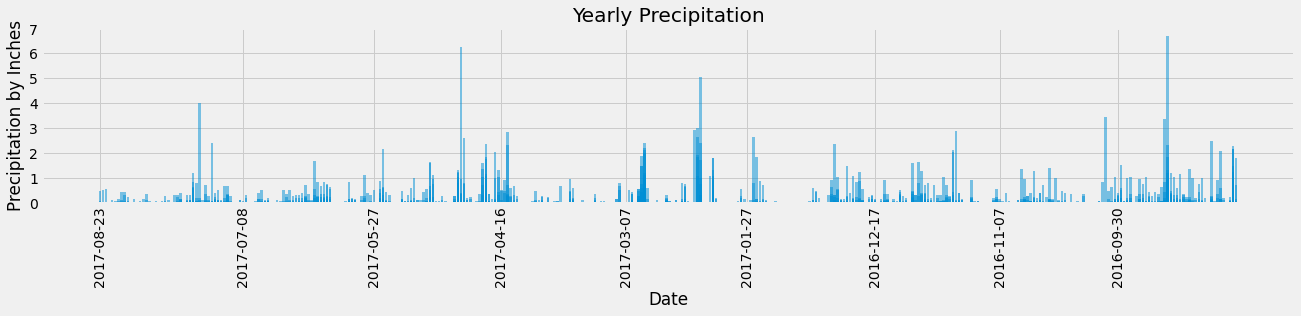

In [307]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Find final date in set
last_date = session.query(measurement.date).\
    order_by(measurement.date.asc()).first()

# Calculate the date one year from the last date in data set.
date(2017,8,23)+relativedelta(months=+12)


# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(measurement.date, measurement.prcp).\
    order_by(measurement.date.asc()).first()


# Save the query results as a Pandas DataFrame and set the index to the date column
stmt = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date <= '2017-08-23').\
    filter(measurement.date >= '2016-08-23').\
    order_by(measurement.date.desc()).statement
precipitation = pd.read_sql_query(stmt, session.bind)
precipitation = precipitation.dropna(how='any')
precipitation.set_index('date', inplace=True, )
precipitation

# Use Pandas Plotting with Matplotlib to plot the data

x_axis = precipitation.index.values
plt.figure(figsize=(20,3))
plt.bar(x_axis, precipitation['prcp'], alpha=0.5)
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, rotation="vertical")
plt.locator_params(nbins=9)
plt.title("Yearly Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation by Inches")
plt.savefig("Precipitation.png")
plt.show()

In [151]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [309]:
precipitation

,prcp
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00
...,...
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02


# Exploratory Station Analysis

In [166]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station.station).count()
total_stations

9

In [181]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.prcp)).group_by(measurement.station).all()
most_active

[('USC00511918', 1932),
 ('USC00513117', 2696),
 ('USC00514830', 1937),
 ('USC00516128', 2484),
 ('USC00517948', 683),
 ('USC00518838', 342),
 ('USC00519281', 2772),
 ('USC00519397', 2685),
 ('USC00519523', 2572)]

In [255]:
#Find minimum, maximum, and average temps for stations USC00519281.
avg_temp = session.query(func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()
max_temp = session.query(func.max(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()
min_temp = session.query(func.min(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()
print(f'The lowest temperate for station USC00519281 is {min_temp}, highest is {max_temp}, and the average is {avg_temp}.')

The lowest temperate for station USC00519281 is [(54.0,)], highest is [(85.0,)], and the average is [(71.66378066378067,)].


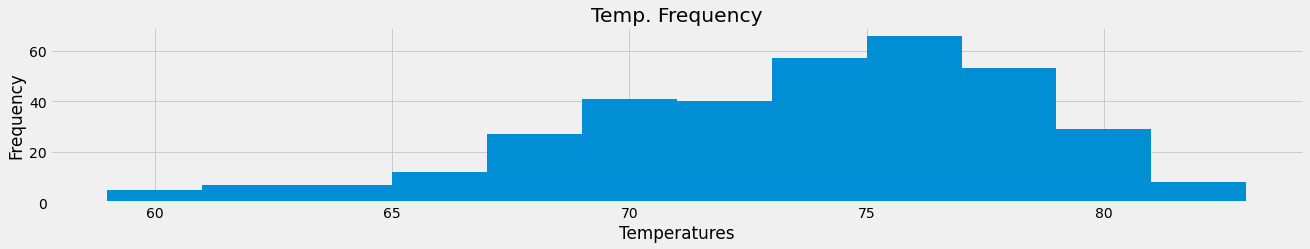

In [299]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(measurement.tobs).\
    filter(measurement.date <= '2017-08-23').\
    filter(measurement.date >= '2016-08-23').\
    filter(measurement.station == 'USC00519281').all()
    
tobs = [77.0, 77.0, 80.0, 80.0, 75.0, 73.0, 78.0, 77.0, 78.0, 80.0, 80.0, 78.0, 78.0, 78.0,
     73.0, 74.0, 80.0, 79.0, 77.0, 80.0,  76.0,  79.0,  75.0,  79.0, 78.0, 79.0, 78.0, 78.0,
     76.0, 74.0, 77.0, 78.0, 79.0, 79.0, 77.0, 80.0, 78.0, 78.0, 78.0, 77.0, 79.0, 79.0, 79.0,
     79.0, 75.0, 76.0, 73.0, 72.0, 71.0, 77.0, 79.0, 78.0, 79.0, 77.0, 79.0, 77.0, 78.0, 78.0,
     78.0, 78.0, 77.0, 74.0, 75.0, 76.0, 73.0, 76.0, 74.0, 77.0, 76.0, 76.0, 74.0, 75.0, 75.0,
     75.0, 75.0, 71.0, 63.0, 70.0, 68.0, 67.0, 77.0, 74.0, 77.0, 76.0, 76.0, 75.0, 76.0, 75.0,
     73.0, 75.0, 73.0, 75.0, 74.0, 75.0, 74.0, 75.0, 73.0, 75.0, 73.0, 73.0, 74.0, 70.0, 72.0,
     70.0, 67.0, 67.0, 69.0, 70.0, 68.0, 69.0, 69.0, 66.0, 65.0, 68.0, 62.0, 75.0, 70.0, 69.0,
     76.0, 76.0, 74.0, 73.0, 71.0, 74.0, 74.0, 72.0, 71.0, 72.0, 74.0, 69.0, 67.0, 72.0, 70.0,
     64.0, 63.0, 63.0, 62.0, 70.0, 70.0, 62.0, 62.0, 63.0, 65.0, 69.0, 77.0, 70.0, 74.0, 69.0,
     72.0, 71.0, 69.0, 71.0, 71.0, 72.0, 72.0, 69.0, 70.0, 66.0, 65.0, 69.0, 68.0, 68.0, 68.0,
     59.0, 60.0, 70.0, 73.0, 75.0, 64.0, 59.0, 59.0, 62.0, 68.0, 70.0, 73.0, 79.0, 75.0, 65.0,
     70.0, 74.0, 70.0, 70.0, 71.0, 71.0, 71.0, 69.0, 61.0, 67.0, 65.0, 72.0, 71.0, 73.0, 72.0,
     77.0, 73.0, 67.0, 62.0, 64.0, 67.0, 66.0, 81.0, 69.0, 66.0, 67.0, 69.0, 66.0, 68.0, 65.0,
     74.0, 69.0, 72.0, 73.0, 72.0, 71.0, 76.0, 77.0, 76.0, 74.0, 68.0, 73.0, 71.0, 74.0, 75.0,
     70.0, 67.0, 71.0, 67.0, 74.0, 77.0, 78.0, 67.0, 70.0, 69.0, 69.0, 74.0, 78.0, 71.0, 67.0,
     68.0, 67.0, 76.0, 69.0, 72.0, 76.0, 68.0, 72.0, 74.0, 70.0, 67.0, 72.0, 60.0, 65.0, 75.0,
     70.0, 75.0, 70.0, 79.0, 75.0, 70.0, 67.0, 74.0, 70.0, 75.0, 76.0, 77.0, 74.0, 74.0, 74.0,
     69.0, 68.0, 76.0, 74.0, 71.0, 71.0, 74.0, 74.0, 74.0, 74.0, 80.0, 74.0, 72.0, 75.0, 80.0,
     76.0, 76.0, 77.0, 75.0, 75.0, 75.0, 75.0, 72.0, 74.0, 74.0, 74.0, 76.0, 74.0, 75.0, 73.0,
     79.0, 75.0, 72.0, 72.0, 74.0, 72.0, 72.0, 77.0, 71.0, 73.0, 76.0, 77.0, 76.0, 76.0, 79.0,
     81.0, 76.0, 78.0, 77.0, 74.0, 75.0, 78.0, 78.0, 69.0, 72.0, 74.0, 74.0, 76.0, 80.0, 80.0,
     76.0, 76.0, 76.0, 77.0, 77.0, 77.0, 82.0, 75.0, 77.0, 75.0, 76.0, 81.0, 82.0, 81.0, 76.0,
     77.0, 82.0, 83.0, 77.0, 77.0, 77.0, 76.0, 76.0, 79.0]

#create histogram from temp data
plt.figure(figsize=(20,3))
plt.hist(tobs, bins=12)
plt.title("Temp. Frequency")
plt.xlabel("Temperatures")
plt.ylabel("Frequency")
plt.savefig("Temp_Frequency.png")
plt.show()

In [278]:
temps

[(77.0),
 (77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (75.0),
 (74.0),
 (75.0),
 (74.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (73.0),
 (74.0),
 (70.0),
 (72.0),
 (70.0),
 (67.0),
 (67.0),
 (69.0),
 (70.0),
 (68.0),
 (69.0),
 (69.0),
 

# Close session

In [298]:
# Close Session
session.close()